# Pairwise NR - PCA

In [ ]:
%pip show pyreflect

In [ ]:
%pip install allpairspy

In [1]:
import numpy as np
from allpairspy import AllPairs
from tqdm.auto import tqdm
from refl1d.names import *
from scipy.interpolate import CubicSpline
from itertools import product

/home/qiao.yuqi/.conda/envs/PT_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def calculate_reflectivity(q, model_description, q_resolution=0.0294855):
    """
        Reflectivity calculation using refl1d
    """
    zeros = np.zeros(len(q))
    dq = q_resolution * q / 2.355

    # The QProbe object represents the beam
    probe = QProbe(q, dq, data=(zeros, zeros))

    layers = model_description['layers']
    sample = Slab(material=SLD(name=layers[0]['name'],
                               rho=layers[0]['sld']), interface=layers[0]['roughness'])
    # Add each layer
    for l in layers[1:]:
        sample = sample | Slab(material=SLD(name=l['name'],
                               rho=l['sld'], irho=l['isld']),
                               thickness=l['thickness'], interface=l['roughness'])

    probe.background = Parameter(value=model_description['background'], name='background')
    expt = Experiment(probe=probe, sample=sample)

    q, r = expt.reflectivity()
    z, sld, _ = expt.smooth_profile()
    #this makes all SLD curves have 900 datapoints per curve
    zNew = np.linspace(z[0], z[-1], num=900)
    newCurve = CubicSpline(z, sld)
    sldNew = []
    for i in range(zNew.shape[0]):
      sldNew.append(newCurve(zNew[i]))
    return model_description['scale'] * r, zNew, sldNew

def layer_params_to_tuple(values, param_info):
    """Helper to group [sld, thickness, roughness] by layer index."""
    grouped = {}
    for v, p in zip(values, param_info):
        grouped.setdefault(p['i'], []).append(v)
    return tuple(tuple(v) for k, v in sorted(grouped.items()) if k >= 2)  # skip substrate & SiOx

class ReflectivityModels(object):
    def __init__(self, num_layers, param_values, sio2_bounds, q=None, name='dynamic_layers'):
        """
        num_layers: Number of polymer layers (dynamic layers after SiOx)
        param_values: dict with discrete values for polymer layers
        sio2_bounds: dict {'thickness': [low, high], 'roughness': [low, high]}
        """
        self.num_layers = num_layers
        self.param_values = param_values
        self.sio2_bounds = sio2_bounds

        self.parameters = []
        self.model_description = {'layers': [], 'scale': 1, 'background': 0}

        # Add substrate explicitly (fixed)
        self.model_description['layers'].append({
            'sld': 2.07, 'isld': 0, 'thickness': 0, 'roughness': 1.5215, 'name': 'substrate'
        })

        # Add Si oxide layer with fixed SLD and parameterized thickness/roughness
        sio2_layer_idx = 1
        self.model_description['layers'].append({
            'sld': 3.47, 'isld': 0, 'thickness': sio2_bounds['thickness'][0],
            'roughness': sio2_bounds['roughness'][0], 'name': 'Si oxide'
        })

        # Parameters for Si oxide layer thickness and roughness
        self.parameters.extend([
            {'i': sio2_layer_idx, 'par': 'thickness',
             'values': np.linspace(*sio2_bounds['thickness'], 3).tolist()},
            {'i': sio2_layer_idx, 'par': 'roughness',
             'values': np.linspace(*sio2_bounds['roughness'], 3).tolist()}
        ])

        # Setup polymer layers dynamically starting from idx=2
        polymer_start_idx = 2
        for layer_idx in range(num_layers):
            actual_layer_idx = polymer_start_idx + layer_idx
            for param_name in ['sld', 'thickness', 'roughness']:
                self.parameters.append({
                    'i': actual_layer_idx,
                    'par': param_name,
                    'values': param_values[param_name]
                })

            self.model_description['layers'].append({
                'sld': 0, 'isld': 0, 'thickness': 0, 'roughness': 0,
                'name': f'polymer_layer_{layer_idx+1}'
            })

        # Add air layer explicitly
        self.model_description['layers'].append({
            'sld': 0.0, 'isld': 0, 'thickness': 0, 'roughness': 0, 'name': 'air'
        })

        self._pars_array = []
        self._refl_array = []
        self._smooth_array = []
        self._train_pars = []
        self._train_data = None
        self._config_name = name

        if q is None:
            self.q = np.logspace(np.log10(0.0081), np.log10(0.1975), num=308)
        else:
            self.q = q

    def generate_pairwise_samples(self):
        """
        Generate pairwise parameter combinations with filtering:
        - roughness < 0.5 * thickness for each layer
        - no duplicate (sld, thickness, roughness) across polymer layers
        """
        param_lists = [p['values'] for p in self.parameters]
    
        def filter_func(pars):
            # Step 1: roughness < 0.5 * thickness for all layers
            layer_dict = {}
            for val, p in zip(pars, self.parameters):
                layer_dict.setdefault(p['i'], {})[p['par']] = val
    
            for layer_idx, params in layer_dict.items():
                if 'roughness' in params and 'thickness' in params:
                    if params['roughness'] >= 0.5 * params['thickness']:
                        return False
    
            # Step 2: prevent duplicate polymer layer configs
            layer_tuples = layer_params_to_tuple(pars, self.parameters)
            if len(set(layer_tuples)) != len(layer_tuples):
                return False
    
            return True
    
        pairwise_samples = list(AllPairs(param_lists, filter_func=filter_func))
        
        self._pars_array = np.array(pairwise_samples)
        return self._pars_array

    def compute_reflectivity(self):
        """
        Compute reflectivity for pairwise samples.
        """
        print("Computing reflectivity for pairwise samples")
        if len(self._pars_array) == 0:
            raise ValueError("Generate samples first using generate_pairwise_samples().")

        for pars in tqdm(self._pars_array, desc="Generating reflectivity curves", colour="green"):
            _desc = self.get_model_description(pars)
            r, z, sld = calculate_reflectivity(self.q, _desc)
            self._refl_array.append(r)
            self._smooth_array.append([z, sld])

    def get_model_description(self, pars):
        """
        Map parameters to the reflectivity model description.
        """
        desc = self.model_description.copy()
        desc['layers'] = [layer.copy() for layer in self.model_description['layers']]

        for idx, par in enumerate(self.parameters):
            layer_idx = par['i']
            param_name = par['par']
            desc['layers'][layer_idx][param_name] = pars[idx]

        return desc
        


In [3]:
import numpy as np

def generate_param_values(bounds, num_choices_per_param):
    """
    Generate discrete parameter values from given bounds.

    Parameters:
    - bounds: dict of param: [min, max]
    - num_choices_per_param: int or dict (number of discrete values)

    Returns:
    - param_values: dict with evenly spaced discrete values
    """
    param_values = {}
    for param, (low, high) in bounds.items():
        # Allow custom num_choices per param if dict is given
        if isinstance(num_choices_per_param, dict):
            n_choices = num_choices_per_param.get(param, 3)  # default to 3
        else:
            n_choices = num_choices_per_param

        param_values[param] = np.linspace(low, high, n_choices).tolist()

    return param_values


In [4]:
bounds_polymer={
    'sld': [0.1, 6.4],
    'thickness': [1, 300],
    'roughness': [1, 50]
}

#roughness <= 1/2 thickness
# no same sld layer

# Generate n# discrete choices for each parameter
param_values_polymer = generate_param_values(bounds_polymer, 50)
param_values_polymer

{'sld': [0.1,
  0.2285714285714286,
  0.3571428571428572,
  0.48571428571428577,
  0.6142857142857143,
  0.7428571428571429,
  0.8714285714285716,
  1.0000000000000002,
  1.1285714285714288,
  1.2571428571428573,
  1.385714285714286,
  1.5142857142857145,
  1.6428571428571432,
  1.7714285714285718,
  1.9000000000000004,
  2.028571428571429,
  2.1571428571428575,
  2.285714285714286,
  2.4142857142857146,
  2.542857142857143,
  2.6714285714285717,
  2.8000000000000003,
  2.928571428571429,
  3.0571428571428574,
  3.1857142857142864,
  3.314285714285715,
  3.4428571428571435,
  3.571428571428572,
  3.7000000000000006,
  3.828571428571429,
  3.9571428571428577,
  4.085714285714286,
  4.214285714285714,
  4.342857142857143,
  4.4714285714285715,
  4.6000000000000005,
  4.728571428571429,
  4.857142857142858,
  4.985714285714286,
  5.114285714285715,
  5.242857142857143,
  5.371428571428572,
  5.5,
  5.628571428571429,
  5.757142857142857,
  5.885714285714286,
  6.014285714285714,
  6.14285

In [5]:
# Si oxide layer bounds (fixed SLD)
sio2_bounds = {
    'thickness': [9.7216, 14.624],
    'roughness': [1.108, 2.998]
}

# Instantiate model with 2 polymer layers
model = ReflectivityModels(
    num_layers=5,
    param_values=param_values_polymer,
    sio2_bounds=sio2_bounds
)



# Generate pairwise samples
pairwise_samples = model.generate_pairwise_samples()
print(f"Generated {len(pairwise_samples)} pairwise samples.")



Generated 3779 pairwise samples.


In [6]:
print("Some sample parameter combinations:")
for i, sample in enumerate(model._pars_array[:1]):  # Show first 5
    print(f"Sample {i + 1}: {sample}")

Some sample parameter combinations:
Sample 1: [ 9.7216      1.108       0.1         7.10204082  1.          0.1
  7.10204082  2.          0.1         7.10204082  3.          0.1
 13.20408163  1.          0.1        13.20408163  2.        ]


In [7]:
# Compute reflectivity for generated samples
model.compute_reflectivity()


Computing reflectivity for pairwise samples


Generating reflectivity curves: 100%|██████████| 3779/3779 [00:33<00:00, 114.07it/s]


In [8]:
# process nr sld curves
for sld_arr in model._smooth_array:
    sld_arr[0] = np.array(sld_arr[0]) - np.min(sld_arr[0])

nr_curves = []
sld_curves = []
for i in range(len(model._smooth_array)):
    nr_curves.append(np.array([model.q,model._refl_array[i]]))
    sld_curves.append(np.array(model._smooth_array[i]))

nr_curves = np.stack(nr_curves)
sld_curves = np.stack(sld_curves)
nr_curves.shape, sld_curves.shape

((3779, 2, 308), (3779, 2, 900))

In [9]:
np.save("./data/curves/pairwise_nr_poly_50.npy",nr_curves)
np.save("./data/curves/pairwise_sld_poly_50.npy",sld_curves)

In [10]:
val_nr_curves = np.load("./data/curves/refl_nr_curves_poly.npy")
val_nr_curves.shape

num_samples = 5000  # how many samples you want

indices = np.random.choice(val_nr_curves.shape[0], size=num_samples, replace=False)
samples = val_nr_curves[indices]  # shape: [num_samples, 2, features]

val_nr_curves.shape, samples.shape


((100000, 2, 308), (5000, 2, 308))

In [11]:
pca_val_nr_flat = val_nr_curves.reshape(val_nr_curves.shape[0], -1)
pca_nr_flat = nr_curves.reshape(nr_curves.shape[0],-1)


In [1]:
import numpy as np
expt_data = np.load("./data/curves/expt/combined_expt_denoised_nr.npy")
tr_data = np.load("./data/curves/orig_tr_nr.npy")


In [2]:
from pyreflect.input import DataProcessor

norm_expt,norm_stats = DataProcessor.normalize_xy_curves(expt_data,apply_log=True)
norm_expt.shape, norm_stats

/home/qiao.yuqi/.conda/envs/PT_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


((8, 2, 308),
 {'x': {'min': np.float64(0.008117949234120778),
   'max': np.float64(0.19755525376482383)},
  'y': {'min': np.float64(-6.899283170700069),
   'max': np.float64(-0.0005998611449857752)}})

In [4]:
norm_tr,_ = DataProcessor.normalize_xy_curves(tr_data,apply_log=True,min_max_stats=norm_stats)
norm_tr.shape

(70000, 2, 308)

In [6]:
norm_tr = norm_tr.reshape(norm_tr.shape[0],-1)
norm_expt = norm_expt.reshape(norm_expt.shape[0],-1)

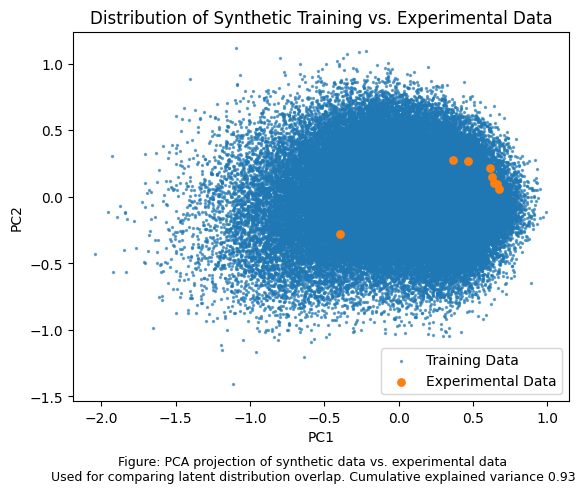

In [17]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

data1 = norm_tr
data2 = norm_expt

# Combine datasets to ensure same PCA space
combined_data = np.vstack([data1, data2])

pca = PCA(n_components=2)
combined_pca = pca.fit_transform(combined_data)

# Separate them again:
pc_data1 = combined_pca[:len(data1)]
pc_data2 = combined_pca[len(data1):]

# Plot
plt.scatter(pc_data1[:,0], pc_data1[:,1], label='Training Data', alpha=0.6,s=2)
plt.scatter(pc_data2[:,0], pc_data2[:,1], label='Experimental Data', alpha=1,s=28)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Distribution of Synthetic Training vs. Experimental Data')
plt.figtext(
    0.5, -0.05,
    "Figure: PCA projection of synthetic data vs. experimental data\n"
    "Used for comparing latent distribution overlap. Cumulative explained variance 0.93",
    wrap=True,
    horizontalalignment='center',
    fontsize=9
)
plt.legend()
plt.grid(False)
plt.savefig("pca_distribution_plot.png", dpi=300)
plt.show()

In [13]:
explained_variance_ratio = pca.explained_variance_ratio_
print("Explained variance ratio per component:", explained_variance_ratio)

# Explained variance (cumulative)
cumulative_variance = np.cumsum(explained_variance_ratio)
print("Cumulative explained variance:", cumulative_variance)


Explained variance ratio per component: [0.78923817 0.14838259]
Cumulative explained variance: [0.78923817 0.93762076]
